In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

import warnings
warnings.filterwarnings('ignore')

# A simple Gaussian Process model for asteroseismology

In this demo, we will fit a Gaussian Process (GP) model to the light curve of the same oscillating star that was used in [the `lightkurve` tutorial on Tuesday](https://colab.research.google.com/github/ojhall94/TASC5_lightkurve/blob/master/Notebooks/Colab-Rudy-example.ipynb).
We'll do the same pre-processing so I'd recommend checking out that tutorial if you haven't seen it before.

This tutorial isn't designed to be a robust or rigorous example of asteroseismic best practices, but it should give you a starting point for trying something more ambitious with GPs and asteroseismology if you're interested.
The key data analysis tools that we'll use in this example are [`lightkurve`](https://docs.lightkurve.org), [`celerite`](https://celerite.readthedocs.io) (as implemented in the [`exoplanet`](https://exoplanet.dfm.io) package), and [PyMC3](https://docs.pymc.io).
There are many other tools for implementing GP models, but `celerite` was specifically designed for astronomical time series applications and the most complete implementation lives in the `exoplanet` package.
`PyMC3` gives us access to gradient-based inference methods like No U-Turn Sampling that make the fitting faster and more robust.

## Installation

To start, you'll need to install the key packages:

In [3]:
!pip install -U -q lightkurve theano pymc3 exoplanet corner

Now let's import them to make sure that they all work:

In [4]:
import corner
import numpy as np
import lightkurve as lk
import astropy.units as u

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

Now we'll download the data and perform the same pre-processing as in the `lightkurve` tutorial, except this time we'll restrict ourselves to about 3 days(!) of data from Quarter 5.
We're going to do this for two reasons.
First, it'll make the code below run a little faster than if we used the full dataset (and maybe even finish before the end of the day!).
Second, GP methods like this tend to be especially relevant for low signal-to-noise examples so we'll artifically decrease the signal-to-noise by using a tiny dataset and comparing to the "ground truth" found using the full dataset.

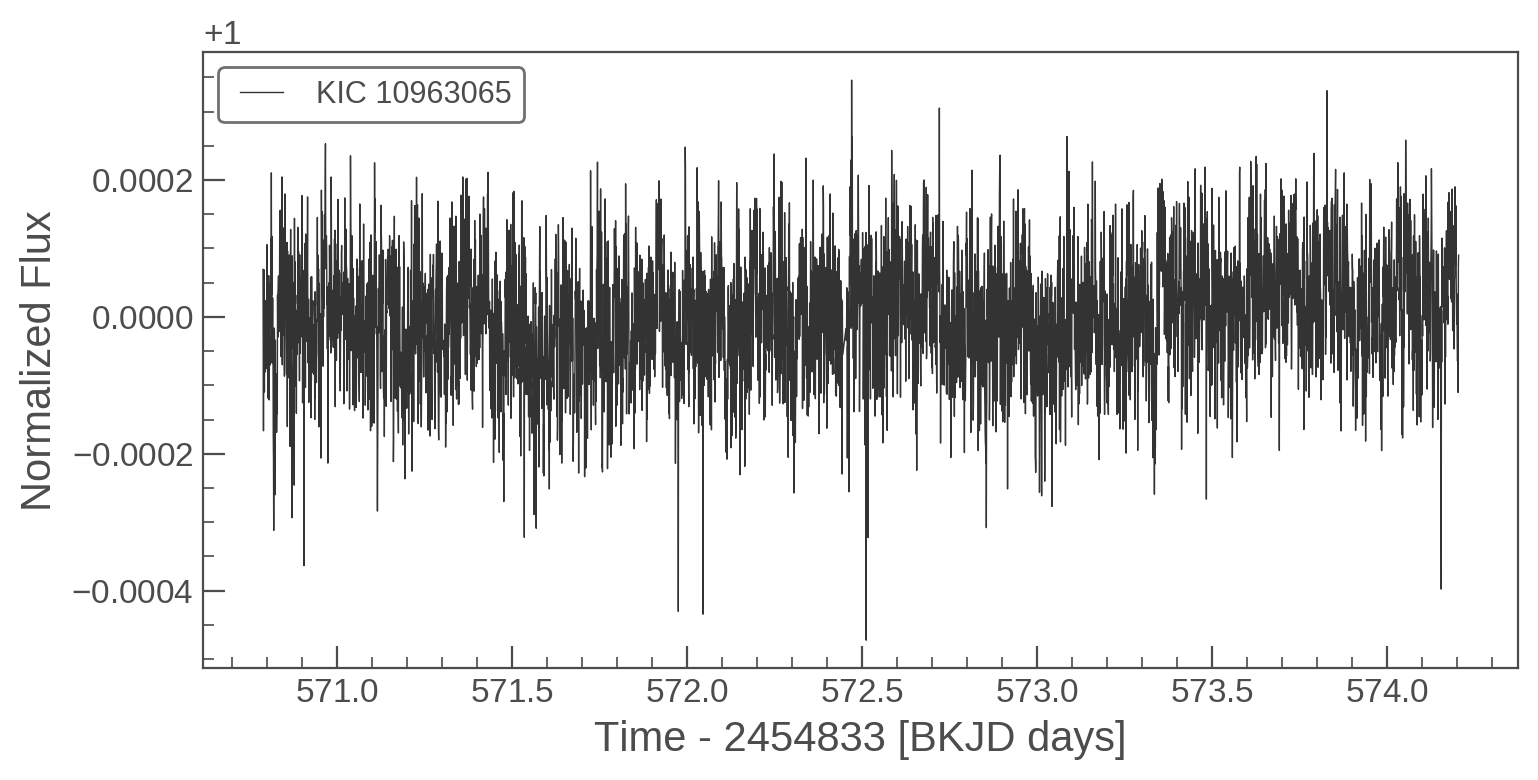

In [5]:
datalist = lk.search_lightcurvefile('KIC10963065', cadence='short')
data = datalist[5:6].download_all()
lc = data.stitch().remove_outliers().remove_nans()
lc = lc[5000:10000]
lc.plot();

Let's look at the periodogram for this dataset:

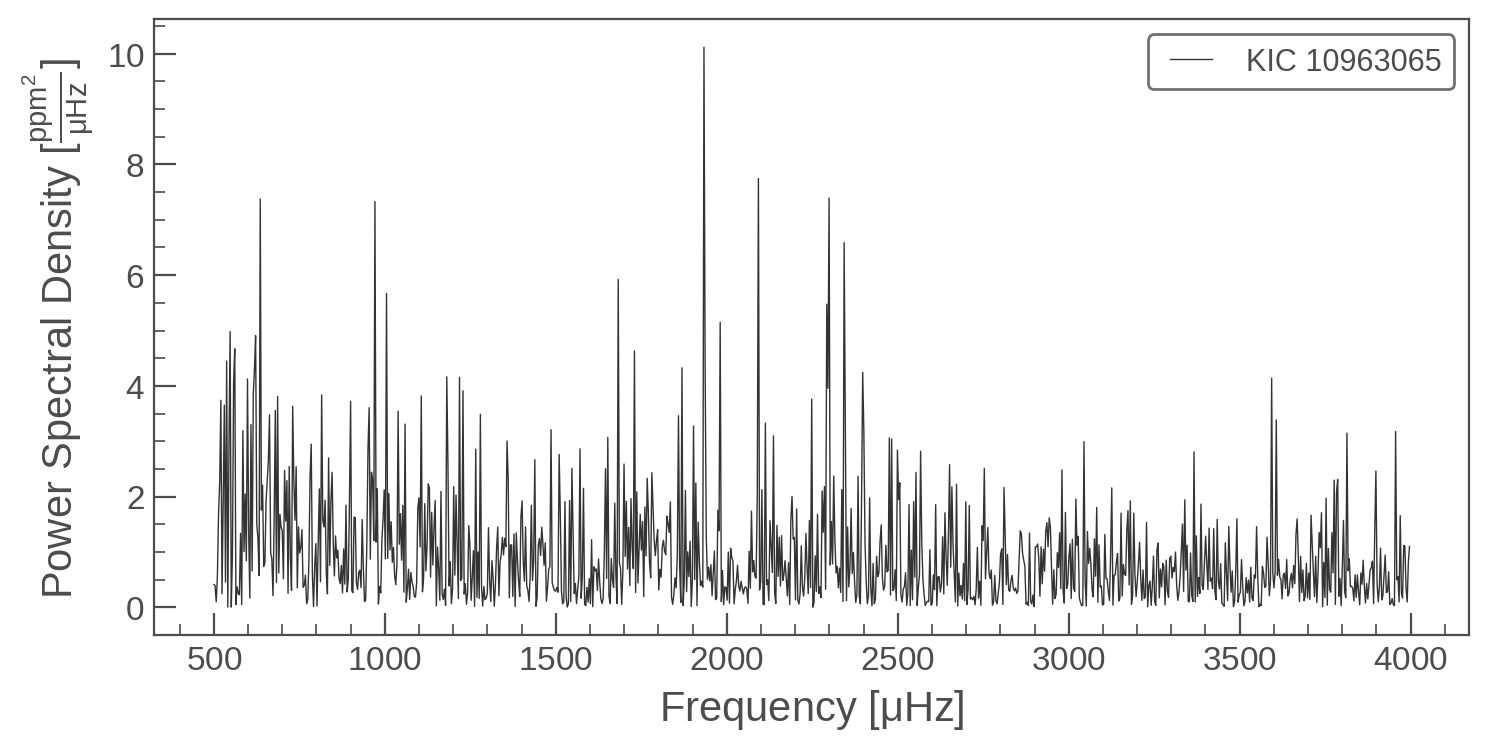

In [6]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd',
                      minimum_frequency=500, maximum_frequency=4000)
pg.plot();

It looks like we can still see the power excess around $\nu_\mathrm{max}$ so let's fit it using the `lightkurve` methods:

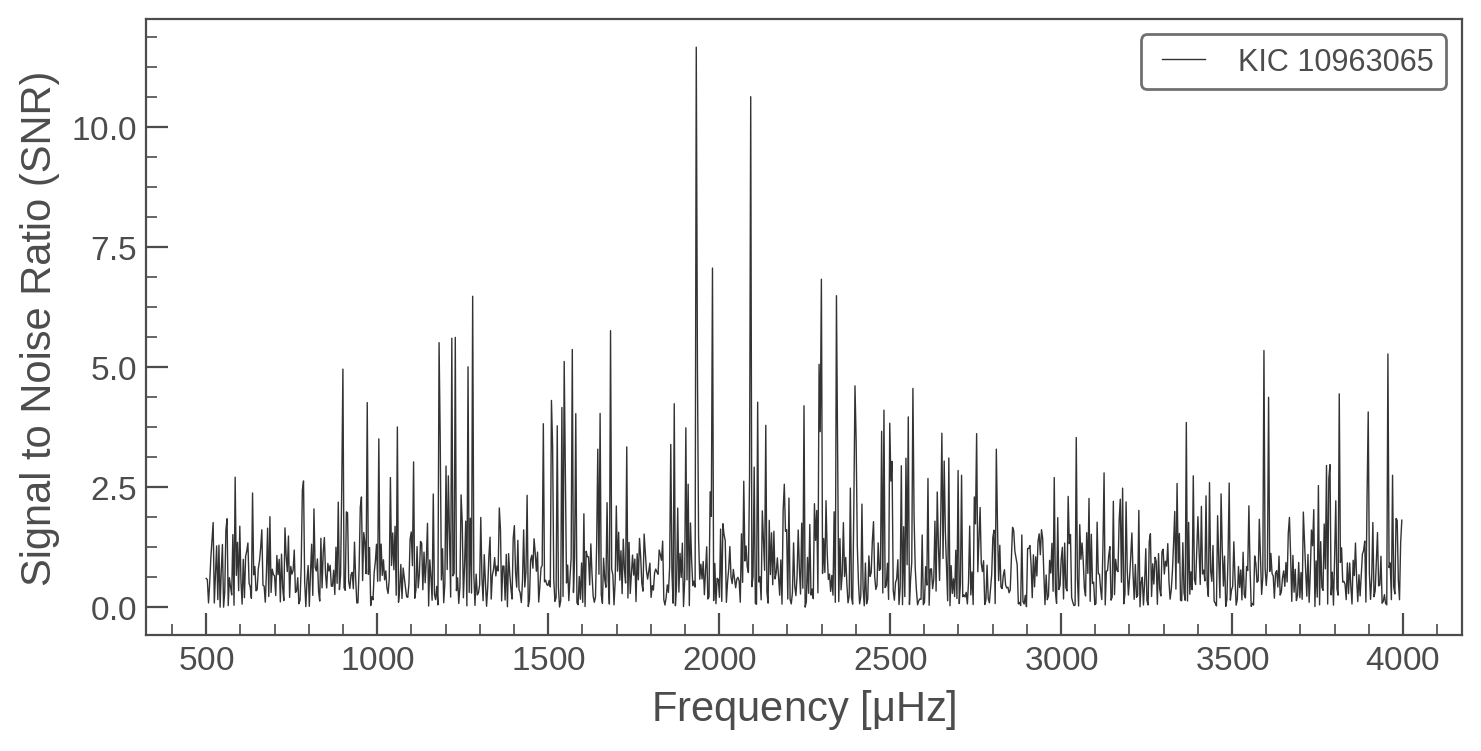

In [7]:
snr = pg.flatten()
seis = snr.to_seismology()
seis.periodogram.plot();

numax_guess =  2085.0 uHz


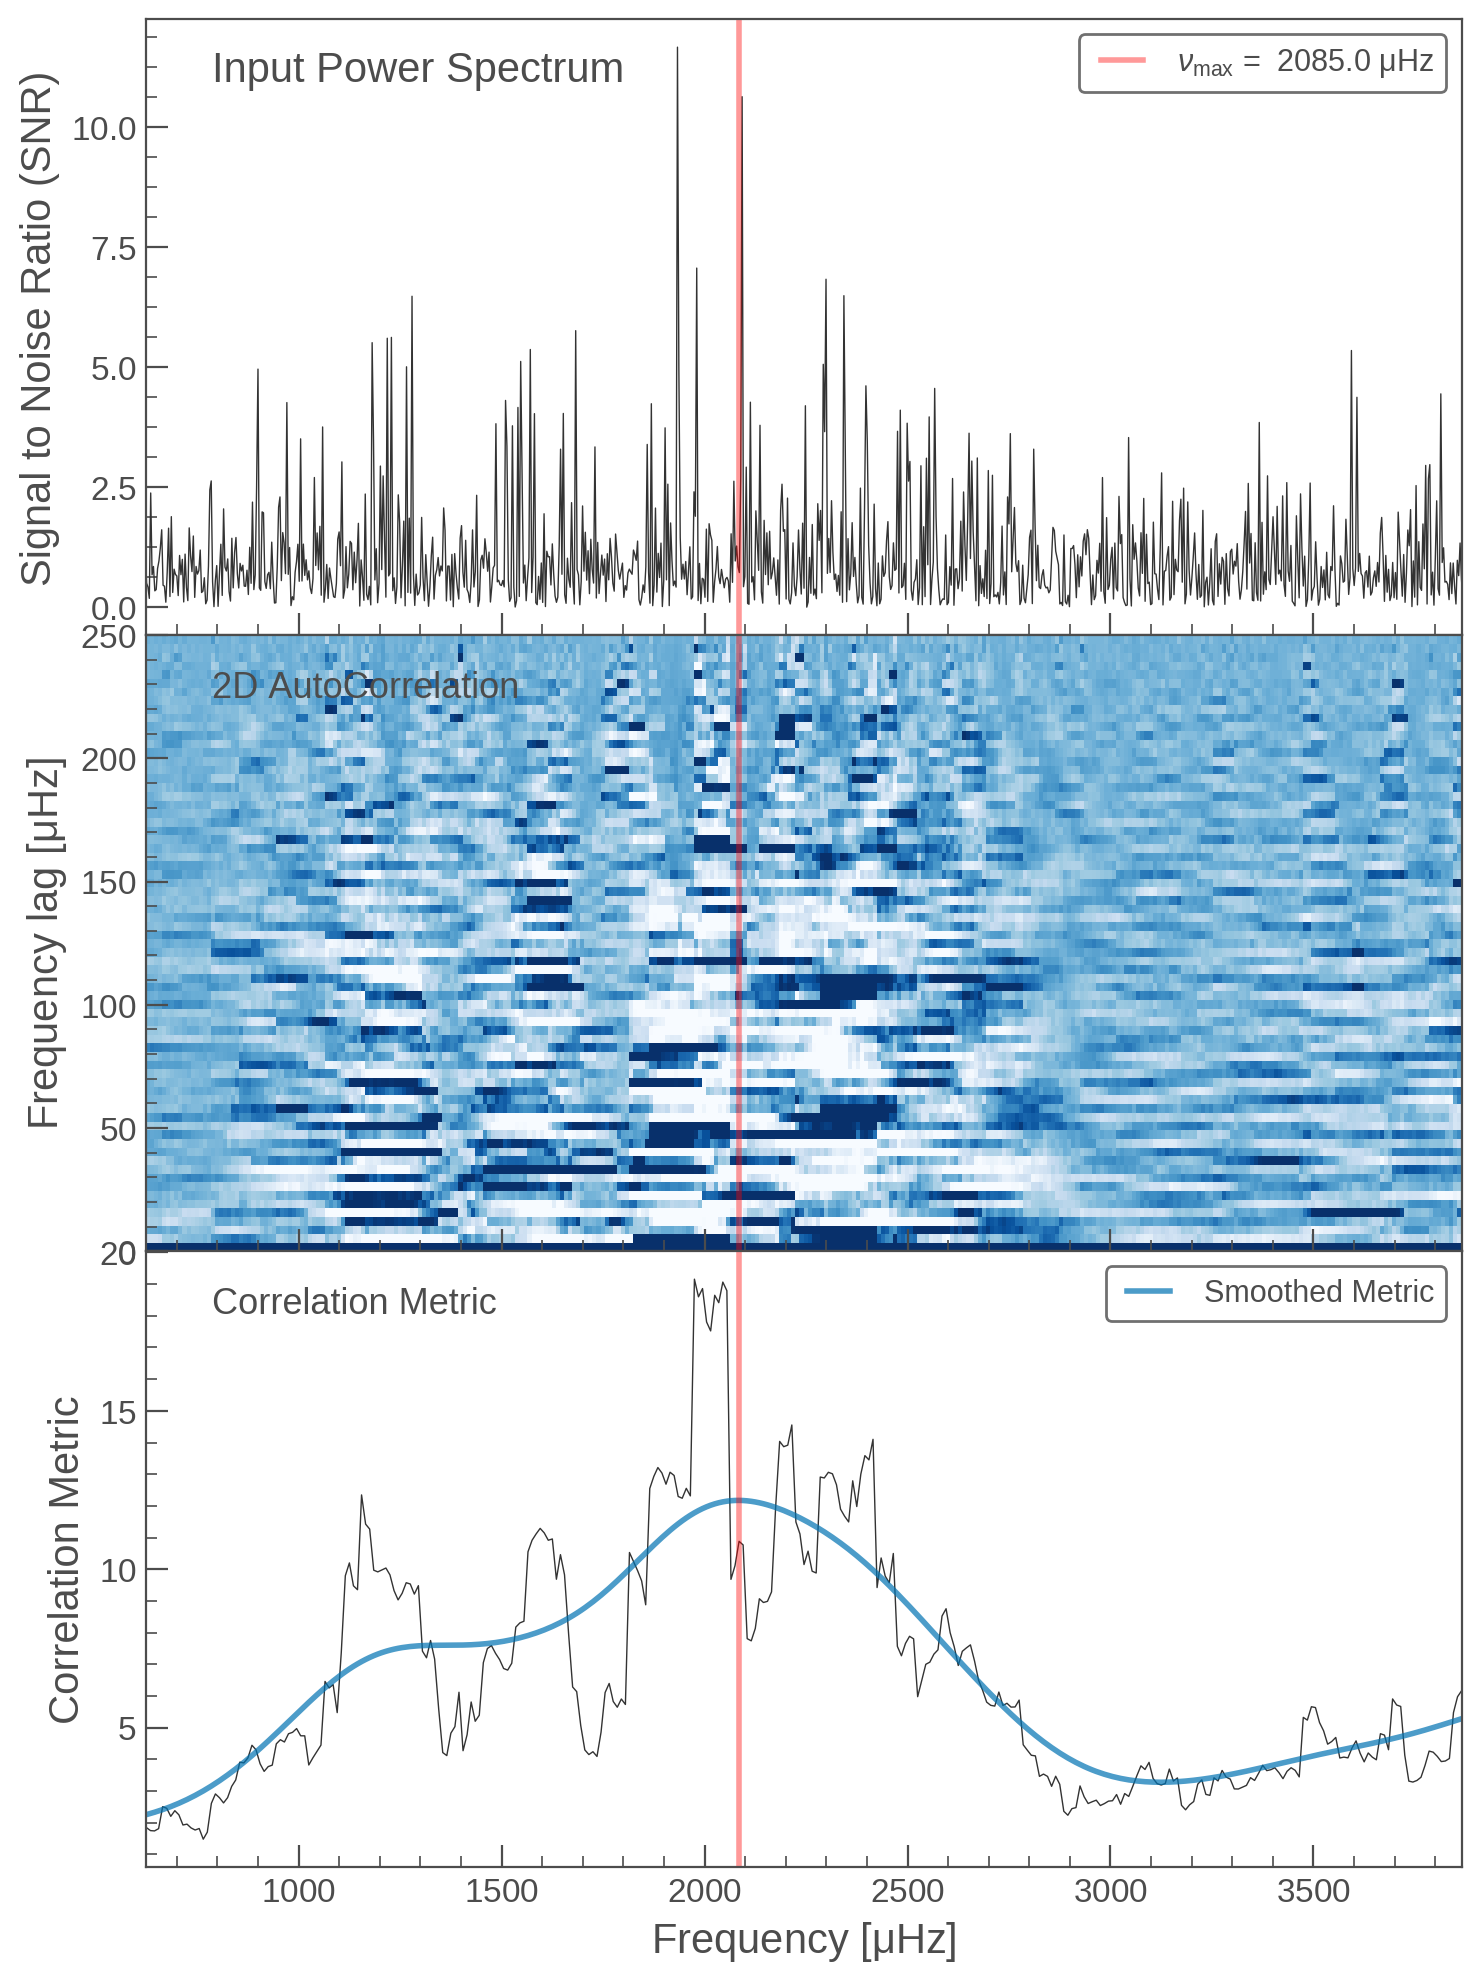

In [8]:
numax_guess = seis.estimate_numax()
print("numax_guess = ", numax_guess)
seis.diagnose_numax();

That looks a little janky, but let's fit it using a GP and see what happens.

## The GP model in PyMC3

We'll use a relatively simple model in this case because it'll be faster to run and it's probably all we can get out of the data.
In this case, we'll use three `celerite` stochastically-driven damped simple harmonic oscillators (SHOs) as the GP kernel.
Two of the SHOs are Harvey models that capture the granulation and the third captures the power excess centered on $\nu_\mathrm{max}$.
Then we'll fit for the paramters of this kernel by evaluating the likelihood *of the light curve* and using MCMC to sample from the posterior density for these parameters conditioned on the data.
For more information about all the parts of this model, take a look at [the `exoplanet` docs](https://exoplanet.dfm.io).

In [9]:
# Make sure that all the data have the right type
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)

# Convert to ppm
y = (y - 1) * 1e6
yerr *= 1e6

# This will be useful for converting between uHz and 1/d for frequencies
uHz_conv = u.uHz.to(1/u.day)

# Build the model in PyMC3
with pm.Model() as gp_model:
    
    # The mean stellar flux (relative to the normalized baseline) in ppm
    mean = pm.Normal("mean", mu=0, sd=np.std(y))
    
    # A jitter term to capture underestimated error bars and model misspecification
    logs2 = pm.Normal("logs2", mu=np.log(np.mean(yerr**2)), sd=10.0)
    
    # The first two terms capture the granulation and they each have 2 parameters:
    #
    # 1. The amplitude of the variability (in ppm^2), and
    # 2. The turnover (angular) frequency in 1/d
    logw_init = np.log(2*np.pi) - np.log([5, 10])
    loga = pm.Normal("loga", mu=np.log(np.var(y)), sd=10.0, shape=2)
    logw0 = pm.Normal("logw0", mu=logw_init, sd=10.0, shape=2)
    logS0 = pm.Deterministic("logS0", loga-logw0+0.5*np.log(2))
    
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0[0], log_w0=logw0[0], Q=1/np.sqrt(2))
    kernel += xo.gp.terms.SHOTerm(log_S0=logS0[1], log_w0=logw0[1], Q=1/np.sqrt(2))

    # The third term captures the power excess and it has 3 parameters:
    #
    # 1. The amplitude of the variability (in ppm^2),
    # 2. The quality factor of the power envelope (constrained to be >0.5), and
    # 3. The central frequency of the power excess (in uHz); we will interpret
    #    this as nu_max
    logQ_peak_init = 1.0
    logw_peak_init = np.log(2*np.pi*uHz_conv*numax_guess.value)
    loga_peak = pm.Normal("loga_peak", mu=np.log(np.var(y)), sd=10.0)
    lognumax = pm.Normal("lognumax", mu=np.log(numax_guess.value), sd=500)
    numax = pm.Deterministic("numax", tt.exp(lognumax))
    w0_peak = pm.Deterministic("w0_peak", 2*np.pi*uHz_conv*numax)
    logQ_peak = pm.Normal("logQ", mu=logQ_peak_init, sd=2.0)
    Q_peak = pm.Deterministic("Q_peak", 0.5+tt.exp(logQ_peak))
    logS_peak = loga_peak - tt.log(w0_peak * Q_peak)

    kernel += xo.gp.terms.SHOTerm(log_S0=logS_peak, w0=w0_peak, Q=Q_peak)
    
    # We put this together and evaluate the GP likelihood
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2))
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Then we maximize the log posterior to find an estimate of the maximum
    # a posteriori (map) parameters. Note: The order of these optimizations
    # has been chosen to work for this problem using a combination of intution
    # and trial and error.
    gp_map_soln = gp_model.test_point
    gp_map_soln = xo.optimize(gp_map_soln, vars=[mean])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[logs2])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[loga_peak])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[loga, logw0])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[loga_peak])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[lognumax])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[mean, logs2, loga, logw0])
    gp_map_soln = xo.optimize(gp_map_soln)

optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -29796.003479371924 -> -29795.718038771894
optimizing logp for variables: ['logs2']
message: Optimization terminated successfully.
logp: -29795.718038771894 -> -29557.244715462544
optimizing logp for variables: ['loga_peak']
message: Optimization terminated successfully.
logp: -29557.244715462544 -> -29436.26044717668
optimizing logp for variables: ['logw0', 'loga']
message: Optimization terminated successfully.
logp: -29436.26044717668 -> -29244.755049021296
optimizing logp for variables: ['loga_peak']
message: Optimization terminated successfully.
logp: -29244.755049021296 -> -29176.547053809045
optimizing logp for variables: ['lognumax']
message: Optimization terminated successfully.
logp: -29176.547053809045 -> -29175.83074090756
optimizing logp for variables: ['logw0', 'loga', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -29175.83074090756 -> -29160.904234828155
op

Now we can plot our initial estimate of the power spectrum for our GP model.
**I want to emphasize that we are fitting the light curve directly, but we can still plot our results as a power spectrum.**
No periodograms were harmed in the making of this figure!

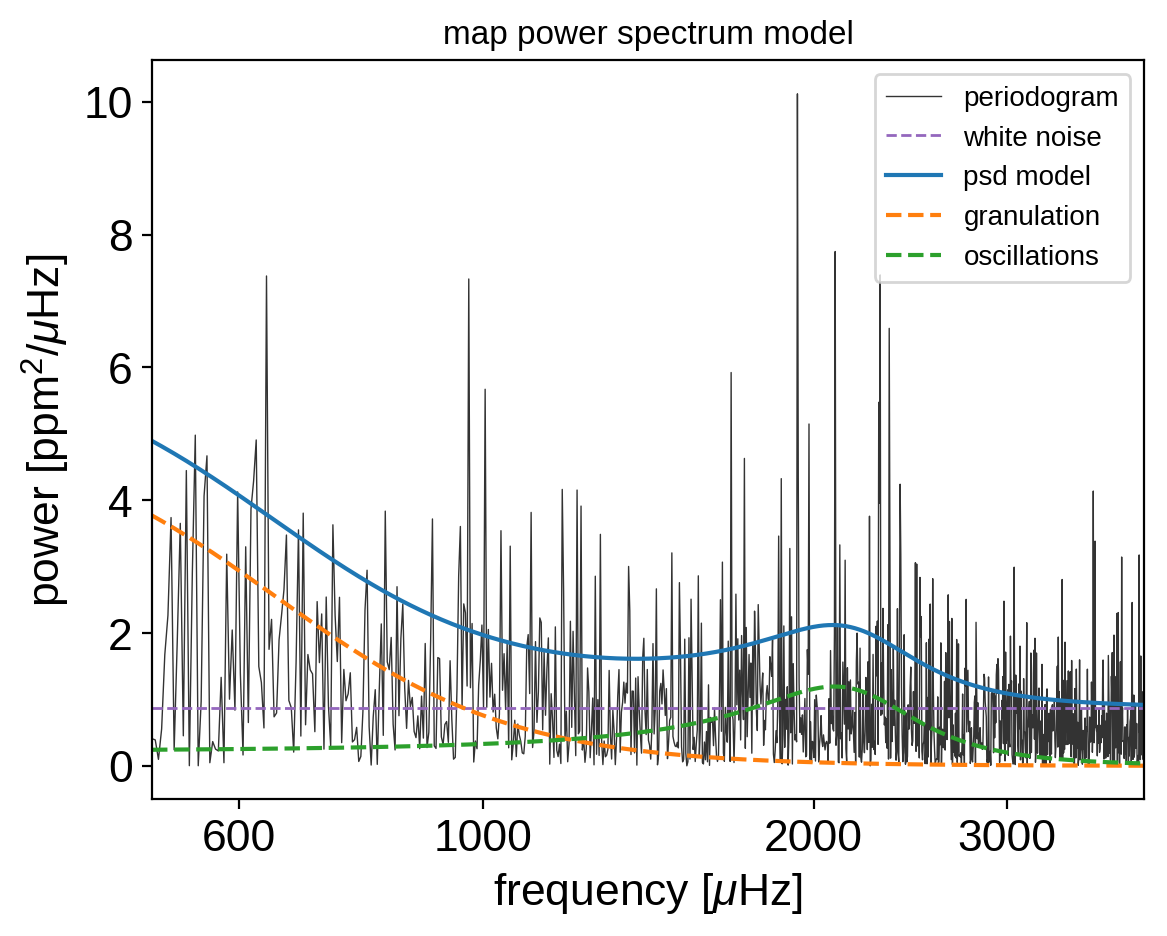

In [10]:
var_ppm = np.mean(yerr**2) + np.exp(gp_map_soln["logs2"])
wn = 0.25*(x.max() - x.min()) * var_ppm / len(x)
logf = np.log10(pg.frequency.value)

plt.plot(logf, pg.power.value, "k", lw=0.5, alpha=0.8, label="periodogram")
plt.axhline(wn, lw=1, color="C4", ls="dashed", label="white noise")

labels = ["granulation", "oscillations"]
with gp_model:
    psd = gp.kernel.psd(2*np.pi*pg.frequency.to(1/u.day).value)
    plt.plot(logf, xo.eval_in_model(psd, gp_map_soln) + wn, label="psd model")
    for i, term in enumerate(gp.kernel.terms):
        psd = term.psd(2*np.pi*pg.frequency.to(1/u.day).value)
        plt.plot(logf, xo.eval_in_model(psd, gp_map_soln), "--", label=labels[i])

plt.xlim(logf.min(), logf.max())
plt.xticks(np.log10([600, 1000, 2000, 3000]))
plt.gca().set_xticklabels(["600", "1000", "2000", "3000"])
plt.legend(fontsize=10, loc=1)
plt.xlabel("frequency [$\mu$Hz]")
plt.ylabel("power [ppm$^2/\mu$Hz]")
plt.title("map power spectrum model", fontsize=12);

## Sampling

Now that we have an estimate of the map parameters, we'll run MCMC to estimate the error bars and covariances between all the parameter.
In particular, we will be looking at our posterior estimate of $\nu_\mathrm{max}$ (made using 3 days of data) compared to the value estimated from the full dataset.

Since we defined our model using `PyMC3`, we can use the inference methods implemented by that project to efficiently run MCMC and estimate the marginalization integrals for the parameters that we care about.

In [11]:
sampler = xo.PyMC3Sampler()
with gp_model:
    sampler.tune(tune=3000, start=gp_map_soln, step_kwargs=dict(target_accept=0.9))
    gp_trace = sampler.sample(draws=3000)

Sampling 2 chains: 100%|██████████| 104/104 [00:09<00:00, 10.53draws/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logQ, lognumax, loga_peak, logw0, loga, logs2, mean]
Sampling 2 chains: 100%|██████████| 6000/6000 [04:57<00:00, 10.72draws/s]
The number of effective samples is smaller than 25% for some parameters.


It's always good to look at a summary of the results, in particular looking at the `n_eff` column which is an estimate of the number of effective samples for each parameter.

In [12]:
pm.summary(gp_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-88.279812,29.500280,0.959191,-140.015637,-30.939377,960.988280,1.000217
logs2,6.570484,0.219470,0.003762,6.128083,6.964578,3067.769876,1.000123
loga__0,7.311470,0.173907,0.004771,7.016133,7.599525,1204.338189,0.999981
loga__1,6.665319,1.298563,0.039188,4.834493,9.381320,1024.524978,1.000095
logw0__0,5.793706,0.174154,0.004514,5.476447,6.089616,1287.118233,1.000106
logw0__1,0.976891,0.827610,0.022584,-0.813062,2.451052,1269.335878,1.000003
loga_peak,6.723837,0.274413,0.006276,6.162555,7.268578,1578.998485,0.999930
lognumax,7.703835,0.057261,0.000841,7.597118,7.821627,3316.034306,0.999841
logQ,0.209825,0.712841,0.020557,-1.203930,1.311362,1040.747111,1.000108
logS0__0,1.864338,0.139739,0.002032,1.598016,2.141036,5001.431870,0.999863


This looks pretty good so we can also plot the covariances between $\nu_\mathrm{max}$ and the other parameters of the term describing the oscillations.

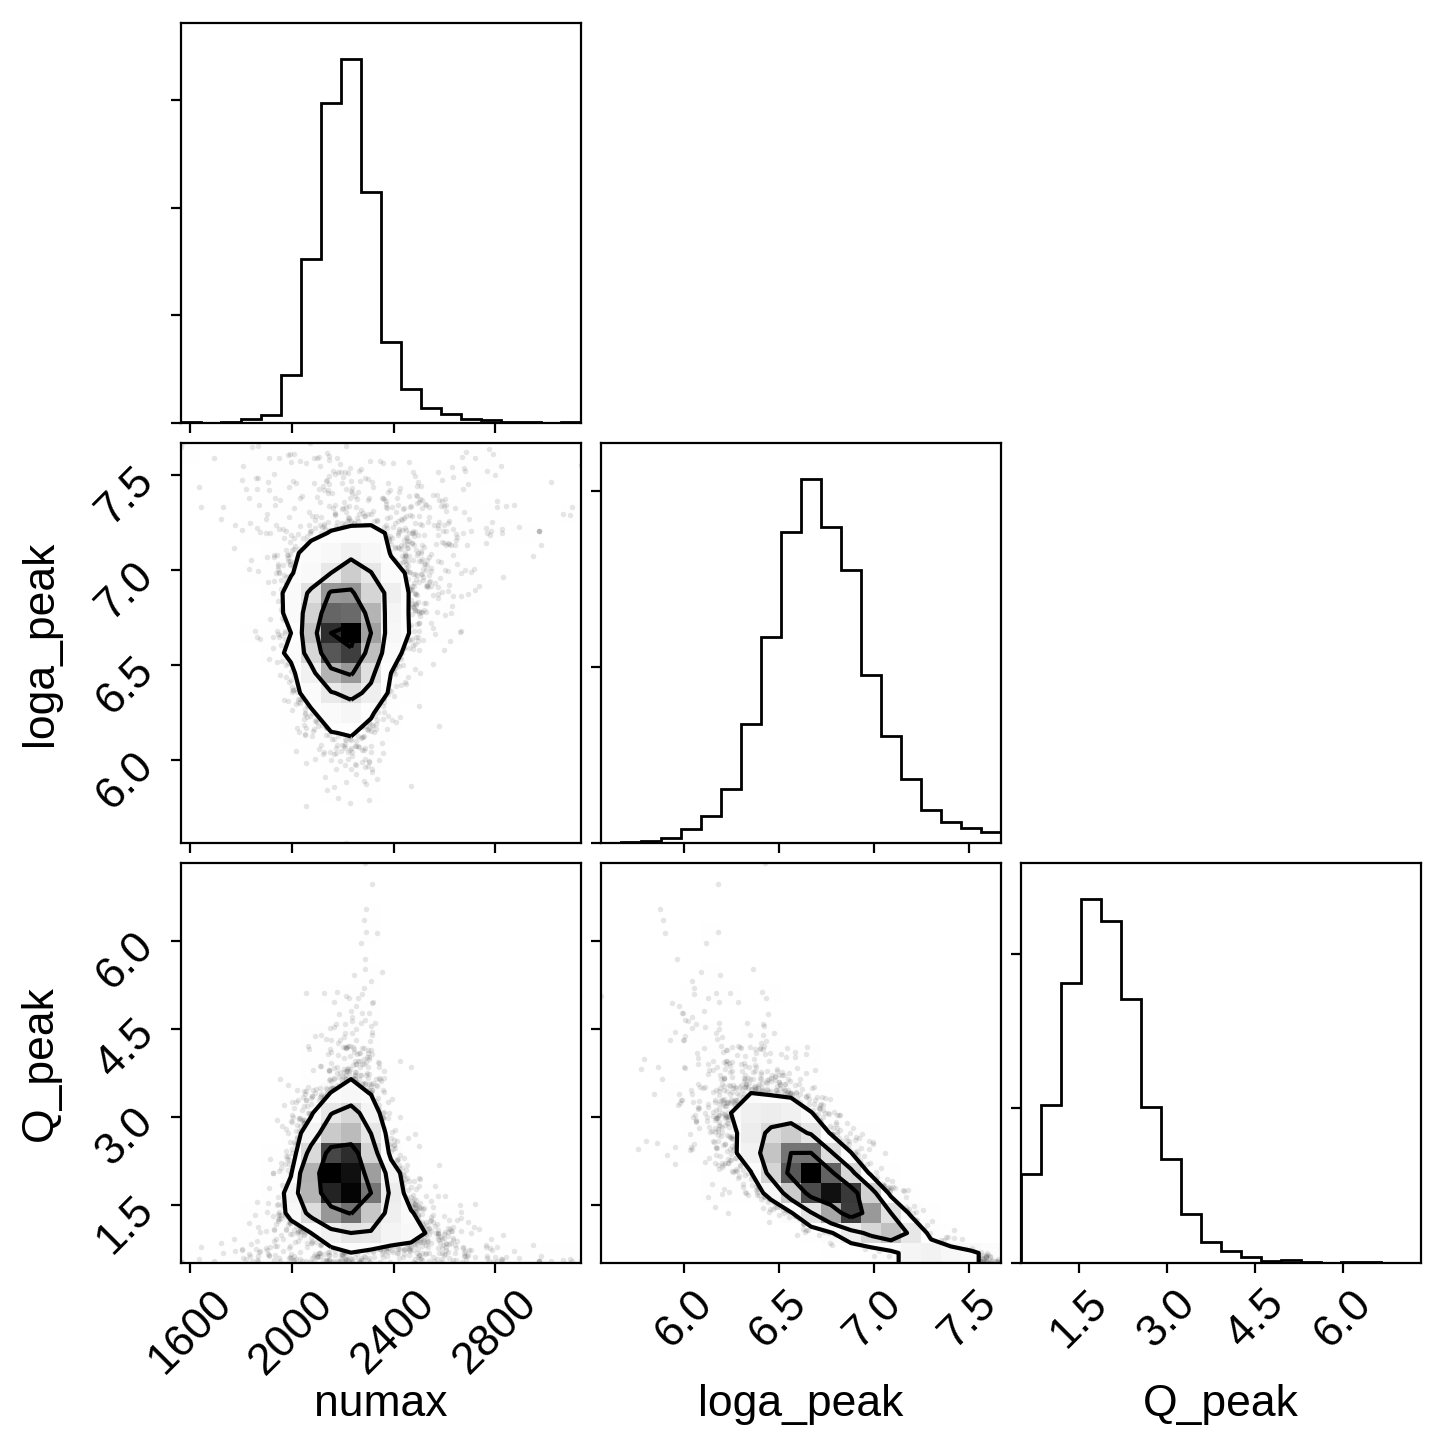

In [13]:
corner.corner(pm.trace_to_dataframe(gp_trace, varnames=["numax", "loga_peak", "Q_peak"]));

We can also plot these results as a posterior constraint on the power spectrum model.

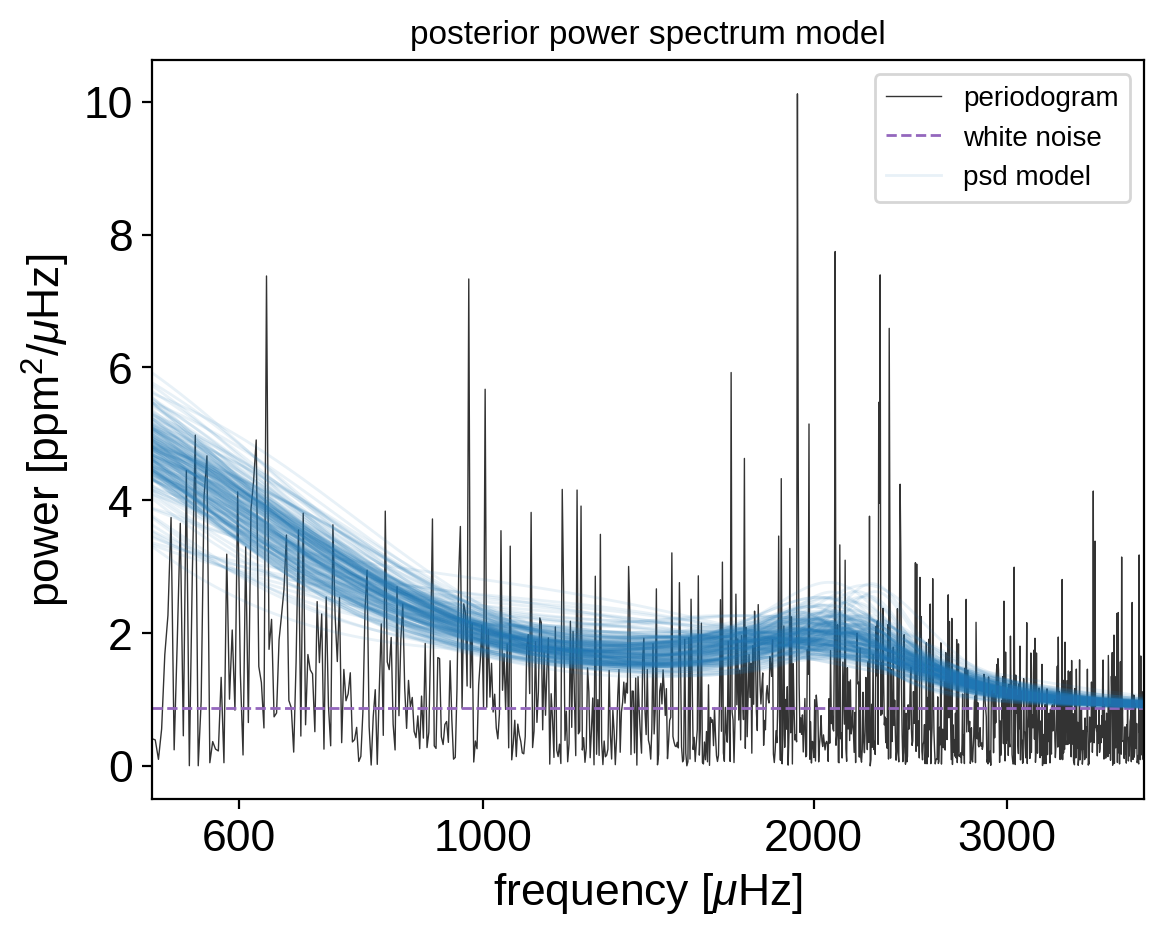

In [14]:
logf = np.log10(pg.frequency.value)

plt.plot(logf, pg.power.value, "k", lw=0.5, alpha=0.8, label="periodogram")

var_ppm = np.mean(yerr**2) + np.exp(np.median(gp_trace["logs2"]))
wn = 0.25*(x.max() - x.min()) * var_ppm / len(x)
plt.axhline(np.mean(wn), lw=1, color="C4", linestyle="dashed", label="white noise")

with gp_model:
    psd = gp.kernel.psd(2*np.pi*pg.frequency.to(1/u.day).value)
    var_ppm = np.mean(yerr**2) + tt.exp(gp_model.logs2)
    wn = 0.25*(x.max() - x.min()) * var_ppm / len(x)
    func = xo.get_theano_function_for_var(psd + wn)
    label = "psd model"
    for sample in xo.utils.get_samples_from_trace(gp_trace, size=200):
        plt.plot(logf, func(*xo.get_args_for_theano_function(sample)), color="C0", alpha=0.1, lw=1,
                 label=label)
        label = None

plt.xlim(logf.min(), logf.max())
plt.xticks(np.log10([600, 1000, 2000, 3000]))
plt.gca().set_xticklabels(["600", "1000", "2000", "3000"])
plt.legend(fontsize=10, loc=1)
plt.xlabel("frequency [$\mu$Hz]")
plt.ylabel("power [ppm$^2/\mu$Hz]")
plt.title("posterior power spectrum model", fontsize=12);

We can see here that it looks like there is a peak, but that it's location isn't very well constrained (what'd you expect with this dataset?!).
Another way of visualizing this is to plot the posterior histogram for $\nu_\mathrm{max}$.

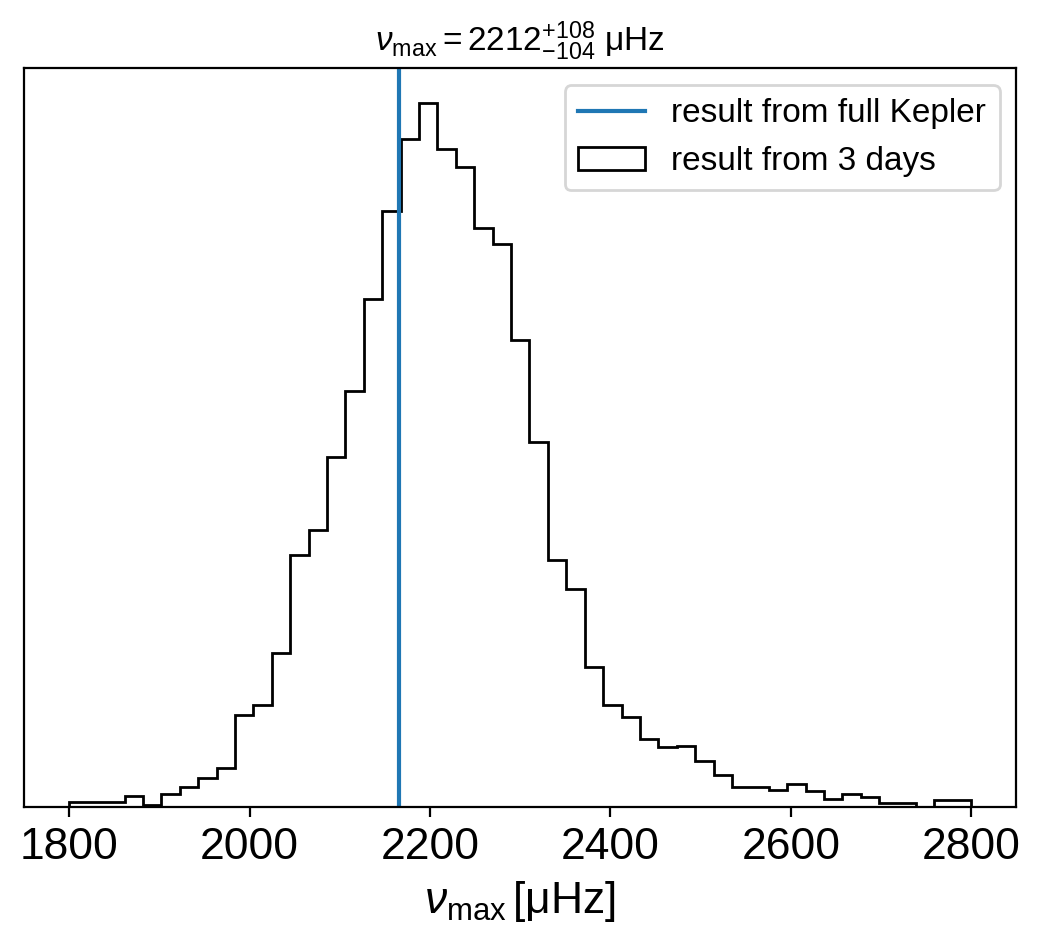

In [15]:
bins = np.linspace(1800, 2800, 50)
plt.hist(gp_trace["numax"], bins, histtype="step", color="k", lw=1,
         label="result from 3 days")
plt.axvline(2165, label="result from full Kepler")
plt.legend(fontsize=12)
plt.yticks([])
plt.xlabel("$\\nu_\mathrm{max} \, [\mathrm{\mu Hz}]$")

q = np.percentile(gp_trace["numax"], [16, 50, 84])
plt.title("$\\nu_\mathrm{{max}} = {0:.0f}_{{-{1:.0f}}} ^{{+{2:.0f}}}\,\,\mathrm{{\mu Hz}}$"
          .format(q[1], *np.diff(q)), fontsize=12);

It's over.